# Setups, Installations and Imports

In [ ]:
!pip install tensorflow-gpu==2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0


In [ ]:
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.11.0


In [ ]:
import wandb
from wandb.keras import WandbCallback

!wandb login 69f60a7711ce6b8bbae91ac6d15e45d6b1f1430e

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

# Prepare Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#### Visualization of Cifar 10

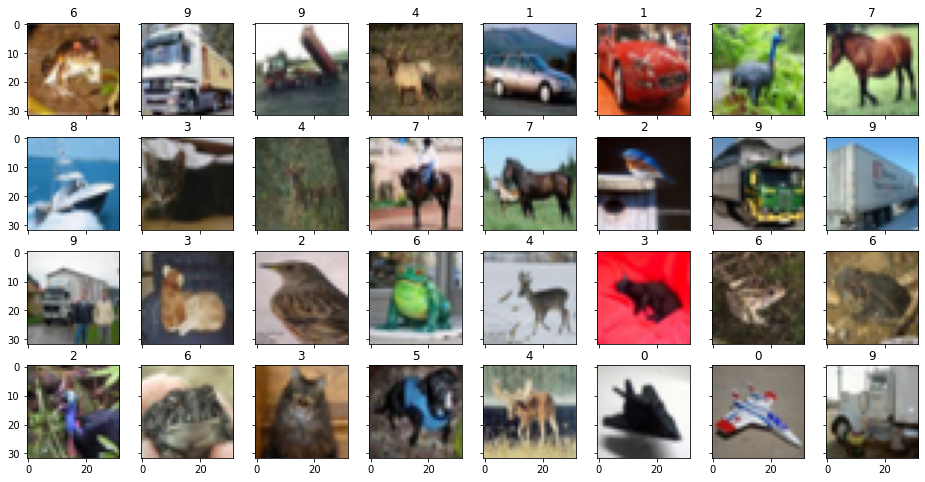

In [ ]:
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

#### Data Generator with Patch Augmentation

In [ ]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.y = y
      self.X = X
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
      X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
      y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))

      x = y = np.random.randint(0, 31, 1)[0]
      w = h = np.random.randint(1, 10, 1)[0]

      for i, idx in enumerate(idxs):
        tmp_image = self.X[idx].copy()

        mask = np.full(tmp_image.shape, 255, np.uint8)
        mask[y:y+h,x:x+w] = 0
        res = cv2.bitwise_and(tmp_image, mask)

        X_batch[i,] = res/255
        y_batch[i] = self.y[idx]/255

      return X_batch, y_batch

In [ ]:
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test)

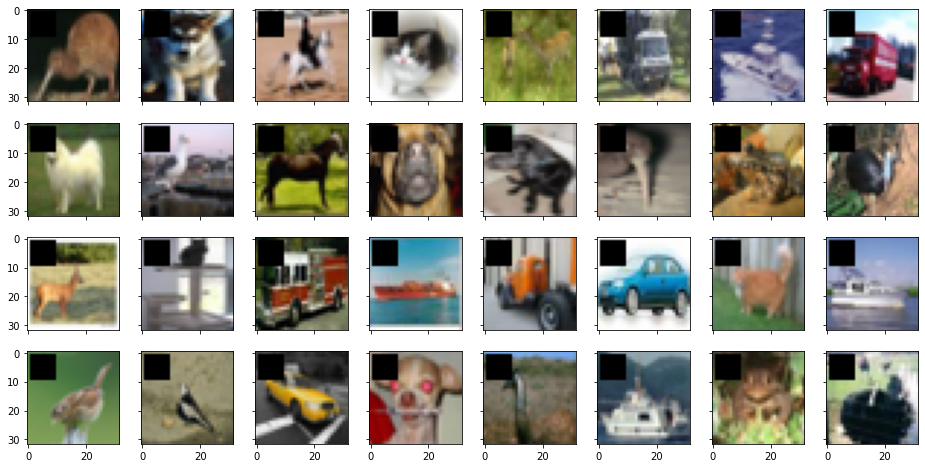

In [ ]:
## Examples
sample_idx = 99 ## Change this to see different batches

sample_images, sample_labels = traingen[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

## Autoencoder-Decoder Model

In [ ]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

In [ ]:
def unet_like():
  inputs = keras.layers.Input((32, 32, 3))
  conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
  #conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  #conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  #pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
  #conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  #conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  #pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
  #conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  #conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

  up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv2), conv1], axis=3)
  conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
  conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
  #up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=3)
  #conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
  #conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
  #up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  #conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
  #conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
  #up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  #conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
  #conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
  conv10 = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv6)

  return keras.models.Model(inputs=[inputs], outputs=[conv10])

In [ ]:
keras.backend.clear_session()
model = unet_like()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

# Train

In [ ]:
wandb.init(entity='ayush-thakur', project="image-impainting")

wandb: Currently logged in as: ayush-thakur. Use `wandb login --relogin` to force relogin


In [ ]:
model.fit(traingen, validation_data=testgen,
          epochs=20,
          steps_per_epoch=len(traingen),
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
   5/1562 [..............................] - ETA: 56s - loss: 0.6834 - dice_coef: 0.5132

1562/1562 [==============================] - ETA: 0s - loss: 0.5532 - dice_coef: 0.6015

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 84s 45ms/step - loss: 0.5532 - dice_coef: 0.6015 - val_loss: 0.5499 - val_dice_coef: 0.6014
Epoch 2/20
1562/1562 [==============================] - ETA: 0s - loss: 0.5487 - dice_coef: 0.6047

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 69s 44ms/step - loss: 0.5487 - dice_coef: 0.6047 - val_loss: 0.5495 - val_dice_coef: 0.6102
Epoch 3/20
1562/1562 [==============================] - ETA: 0s - loss: 0.5483 - dice_coef: 0.6050

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 68s 43ms/step - loss: 0.5483 - dice_coef: 0.6050 - val_loss: 0.5491 - val_dice_coef: 0.6060
Epoch 4/20
1562/1562 [==============================] - ETA: 0s - loss: 0.5481 - dice_coef: 0.6050

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 67s 43ms/step - loss: 0.5481 - dice_coef: 0.6050 - val_loss: 0.5489 - val_dice_coef: 0.6057
Epoch 5/20
1562/1562 [==============================] - 65s 42ms/step - loss: 0.5480 - dice_coef: 0.6051 - val_loss: 0.5492 - val_dice_coef: 0.6096
Epoch 6/20
1562/1562 [==============================] - 65s 41ms/step - loss: 0.5479 - dice_coef: 0.6052 - val_loss: 0.5492 - val_dice_coef: 0.6128
Epoch 7/20
1561/1562 [============================>.] - ETA: 0s - loss: 0.5479 - dice_coef: 0.6052

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 67s 43ms/step - loss: 0.5479 - dice_coef: 0.6052 - val_loss: 0.5488 - val_dice_coef: 0.6047
Epoch 8/20
1562/1562 [==============================] - 65s 42ms/step - loss: 0.5479 - dice_coef: 0.6052 - val_loss: 0.5488 - val_dice_coef: 0.6094
Epoch 9/20
1561/1562 [============================>.] - ETA: 0s - loss: 0.5478 - dice_coef: 0.6053

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 65s 42ms/step - loss: 0.5478 - dice_coef: 0.6053 - val_loss: 0.5487 - val_dice_coef: 0.6091
Epoch 10/20
1562/1562 [==============================] - ETA: 0s - loss: 0.5477 - dice_coef: 0.6053

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 65s 42ms/step - loss: 0.5477 - dice_coef: 0.6053 - val_loss: 0.5485 - val_dice_coef: 0.6106
Epoch 11/20
1562/1562 [==============================] - 65s 41ms/step - loss: 0.5477 - dice_coef: 0.6053 - val_loss: 0.5486 - val_dice_coef: 0.6098
Epoch 12/20
1562/1562 [==============================] - 64s 41ms/step - loss: 0.5477 - dice_coef: 0.6054 - val_loss: 0.5485 - val_dice_coef: 0.6068
Epoch 13/20
1562/1562 [==============================] - ETA: 0s - loss: 0.5477 - dice_coef: 0.6053

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 66s 42ms/step - loss: 0.5477 - dice_coef: 0.6053 - val_loss: 0.5484 - val_dice_coef: 0.6066
Epoch 14/20
1562/1562 [==============================] - 63s 40ms/step - loss: 0.5476 - dice_coef: 0.6054 - val_loss: 0.5493 - val_dice_coef: 0.6027
Epoch 15/20
1562/1562 [==============================] - 63s 41ms/step - loss: 0.5476 - dice_coef: 0.6054 - val_loss: 0.5485 - val_dice_coef: 0.6097
Epoch 16/20
1562/1562 [==============================] - ETA: 0s - loss: 0.5476 - dice_coef: 0.6054

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 66s 42ms/step - loss: 0.5476 - dice_coef: 0.6054 - val_loss: 0.5484 - val_dice_coef: 0.6060
Epoch 17/20
1562/1562 [==============================] - 64s 41ms/step - loss: 0.5476 - dice_coef: 0.6053 - val_loss: 0.5490 - val_dice_coef: 0.6023
Epoch 18/20
1562/1562 [==============================] - ETA: 0s - loss: 0.5476 - dice_coef: 0.6053

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 65s 41ms/step - loss: 0.5476 - dice_coef: 0.6053 - val_loss: 0.5484 - val_dice_coef: 0.6055
Epoch 19/20
1562/1562 [==============================] - 64s 41ms/step - loss: 0.5476 - dice_coef: 0.6054 - val_loss: 0.5487 - val_dice_coef: 0.6080
Epoch 20/20
1562/1562 [==============================] - ETA: 0s - loss: 0.5475 - dice_coef: 0.6054

wandb: Adding directory to artifact (/content/wandb/run-20230314_210025-8u0nm4gc/files/model-best)... Done. 0.1s


1562/1562 [==============================] - 65s 41ms/step - loss: 0.5475 - dice_coef: 0.6054 - val_loss: 0.5483 - val_dice_coef: 0.6072


# Testing on images

In [ ]:
model.save('impaint_trail1.h5')

In [ ]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Restore the weights
model.load_weights('./checkpoints/my_checkpoint')


# Evaluate the model
loss, acc = model.evaluate(testgen,verbose=2)
print("accuracy: {:10.2f}%".format(100 * acc))

312/312 - 4s - loss: 0.5484 - dice_coef: 0.6073 - 4s/epoch - 12ms/step
accuracy:      60.73%


In [ ]:
im = sample_images[0]
impainted_image = model.predict(im.reshape((1,)+im.shape))

1/1 [==============================] - 0s 430ms/step


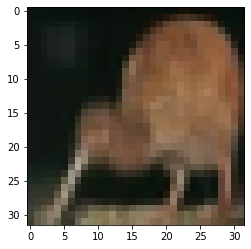

In [ ]:
plt.imshow(impainted_image.reshape(impainted_image.shape[1:]))

1/1 [==============================] - 0s 18ms/step


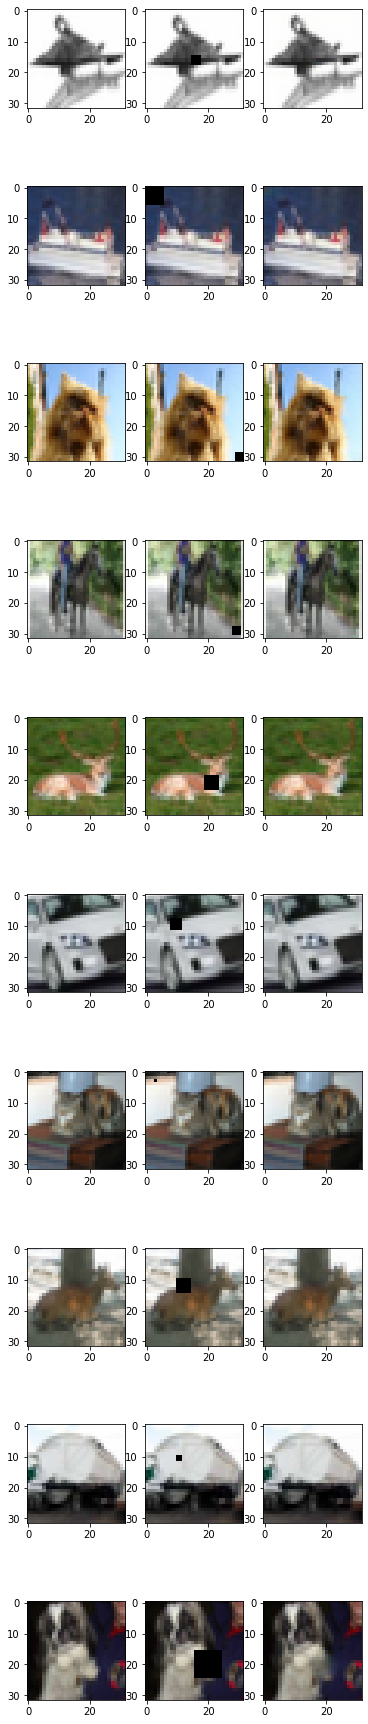

In [ ]:
## Examples
rows = 10
#save_loc='/content/saved_images'
import os
sample_idx = np.random.randint(0, len(testgen), rows)

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 32))

for i, idx in enumerate(sample_idx):
  sample_images, sample_labels = traingen[idx]
  img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
  impainted_image = model.predict(sample_images[img_idx].reshape((1,)+sample_images[img_idx].shape))
  axs[i][0].imshow(sample_labels[img_idx])
  axs[i][1].imshow(sample_images[img_idx])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  #input_loc=os.path.join(save_loc,'input_images',[str(i)+'.png'])
  #output_loc=os.path.join(save_loc,'output_images', [str(i)+'.png'])
  #cv2.imwrite(input_loc,sample_images[img_idx])
  #cv2.imwrite(output_loc,inpainted_image)


plt.show()